# Anomaly Detection Darts Module

The scope of this jupyter notebook is to present the different functionalities of the anomaly detection module. 

The notebook is subdivided into two sections:
- We show the application of a `forecasting anomaly model` on a dataset representing the number of taxi passengers in New York;
- We showcase the utility of the window parameter while applying a `KMeansScorer` on two toy datasets.

First, some necessary imports:

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import datetime

from darts import TimeSeries
from darts.ad.utils import eval_accuracy_from_scores, show_anomalies_from_scores
from darts.ad.anomaly_model.forecasting_am import ForecastingAnomalyModel
from darts.ad.scorers import KMeansScorer, WassersteinScorer, NormScorer
from darts.models import RegressionModel
from darts.datasets import TaxiNewYorkDataset

# Anomaly Model: Taxi passengers in NY

## Load and visualize the data 


Information on the data:
- Univariate Time Series (represents the number of taxi passengers in New York)
- During a period of 8 months (2014-07 to 2015-01)
- Frequency of 30 minutes 

In this example, anomalies are subjective. It can be defined as periods where the demand for taxis is abnormal (different than what should be expected). Based on this definition, the following five dates can be considered anomalies:

- NYC Marathon - 2014-11-02
- Thanksgiving - 2014-11-27
- Christmas - 2014-12-24/25
- New Years - 2015-01-01
- Snow Blizzard - 2015-01-26/27

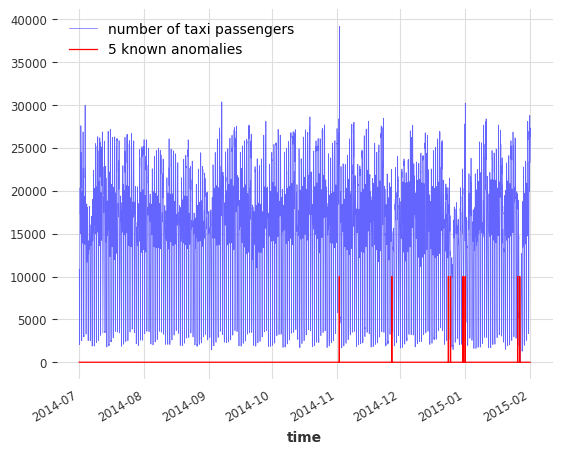

In [77]:
# load the data
series_taxi = TaxiNewYorkDataset().load()

# day of the 5 anomalies (7 days)
anomalies_day = [
    datetime.date(2014, 11, 2),
    datetime.date(2014, 11, 27),
    datetime.date(2014, 12, 24),
    datetime.date(2014, 12, 25),
    datetime.date(2014, 12, 31),
    datetime.date(2015, 1, 1),
    datetime.date(2015, 1, 26),
    datetime.date(2015, 1, 27),
]

# 1: anomalous signal, 0: normal signal
anomalies = np.where(series_taxi.pd_dataframe().index.isin(anomalies_day), 1, 0)

# create binary timeseries indicating the presence of the anomalies
series_taxi_anomalies = TimeSeries.from_times_and_values(
    series_taxi.time_index, anomalies
)

# plot the data and the anomalies
series_taxi.plot(label="number of taxi passengers", linewidth=0.5, color="#6464ff")
(series_taxi_anomalies * 10000).plot(
    label="5 known anomalies", color="r", linewidth=0.9
)
plt.show()

In [78]:
from ipywidgets import interact, widgets
import pandas as pd

plottable_anomalies = {
    "NYC Marathon": datetime.datetime(2014, 11, 2),
    "Thanksgiving ": datetime.datetime(2014, 11, 27),
    "Christmas": datetime.datetime(2014, 12, 25),
    "New Years": datetime.datetime(2014, 12, 31),
    "Snow Blizzard": datetime.datetime(2015, 1, 26),
}

style = {"description_width": "initial"}
anomalies_dropdown = widgets.Dropdown(options=plottable_anomalies.keys(), style=style)
delta_plotted_days = widgets.IntSlider(value=3, min=1, max=25, style=style)


@interact(selected_anomaly=anomalies_dropdown, delta_plotted_days=delta_plotted_days)
def plot(selected_anomaly, delta_plotted_days):
    anomaly_date = plottable_anomalies[selected_anomaly]
    start_timestamp = pd.Timestamp(
        anomaly_date - datetime.timedelta(days=delta_plotted_days)
    )
    end_timestamp = pd.Timestamp(
        anomaly_date + datetime.timedelta(days=delta_plotted_days)
    )

    series_taxi.slice(start_timestamp, end_timestamp).plot(
        label="number of taxi passengers", color="#6464ff", linewidth=0.8
    )

    (series_taxi_anomalies.slice(start_timestamp, end_timestamp) * 10000).plot(
        label="Known anomaly", color="r", linewidth=0.8
    )

    plt.title(selected_anomaly)
    plt.show()

interactive(children=(Dropdown(description='selected_anomaly', options=('NYC Marathon', 'Thanksgiving ', 'Chri…

The goal would be to detect these five irregular periods and identify other possible abnormal days. 

## Train a darts forecasting model

We will use a `RegressionModel` to predict the number of taxi passengers. The first 5900 timestamps will be used to train the model. The training set is considered to be anomaly-free, the five considered anomalies are located after the 5900th timestamps. The number of lags is set to 1 week, assuming the demand follows a periodicity of 1 week. To help the model, additional information on the targeted series is passed as covariates (timestamp’s hour and the day of the week).


In [79]:
s_taxi_train = series_taxi[:5900]

# Add covariates (hour and day of the week)
add_encoders = {
    "cyclic": {"future": ["hour", "dayofweek"]},
}

# one week corresponds to (7 days * 24 hours * 2) of 30 minutes
one_week = 7 * 24 * 2

forecasting_model = RegressionModel(
    lags=one_week, lags_future_covariates=[0], add_encoders=add_encoders
)
forecasting_model.fit(s_taxi_train)

## Use a forecasting anomaly model 

The anomaly model consists of two inputs:
- a fitted forecasting darts model (if not fitted, the parameter `allow_model_training` needs to be set to `True`)
- a list of scorers (trainable or not)

For this example, three scorers will be used:
- `NormScorer` (window is by default set to 1)
- `WassersteinScorer` with a window set at half a day (24 timestamps)
- `WassersteinScorer` with a window set at a full day (48 timestamps)

The window parameter is an integer value indicating the window size used by the scorer to transform the series into an anomaly score. A scorer will slice the given series into subsequences of size W and returns a value indicating how anomalous these subset of W values are.


### Using the main functions: fit(), score(), eval_accuracy() and show_anomalies()

In [80]:
# with timestamps of 30 minutes
half_a_day = 2 * 12
full_day = 2 * 24

anomaly_model = ForecastingAnomalyModel(
    model=forecasting_model,
    scorer=[
        NormScorer(ord=1),
        WassersteinScorer(window=half_a_day),
        WassersteinScorer(window=full_day),
    ],
)

The ForecastingAnomalyModel can be fitted by calling `fit()`. It will first fit the forecasting model on the given series (if not fitted yet, and if the parameter `allow_model_training` is set to `True`). Secondly, the scorers will be fitted on the model's prediction of the given input. 

The parameter `start` indicates the fraction of the input series the scorers should be trained on. It is best if the value is as small as possible, as more data will be used for training. But its value should be higher than the minimum lags required by the forecasting model to make a prediction. 

<span style="color:red">**COMMENT:** Maybe it would be nice to add an image of the data split here, or rephrase a little bit. In particular the start parameter description could be clearer, _value should be higher than the minimum lags_ doesn't sound right given it is a franction and lags are integers</span>.

In [81]:
anomaly_model.fit(s_taxi_train, start=0.2)

To test our anomaly model, we call the function `score()`. We will use the results `anomaly_scores` in the next section. 

In [82]:
s_taxi_test = series_taxi[3400:]
anomaly_scores = anomaly_model.score(s_taxi_test, start=0.2)

<span style="color:red">**COMMENT:** Not clear  why we are taking as test set from 3400 (overlaping with the train set). Also, a couple of words about the start parameter also here would be nice.</span>.

To quantify the success of the anomaly model, we call the function `eval_accuracy()`. It outputs the score of an agnostic threshold metric ("AUC-ROC" or "AUC-PR"), between the predicted anomaly score time series and some known binary ground-truth time series indicating the presence of actual anomalies. 

It will return a dictionary containing the score of each scorer. 

In [83]:
auc_roc_taxi = anomaly_model.eval_accuracy(
    actual_anomalies=series_taxi_anomalies,
    series=s_taxi_test,
    start=0.2,
    metric="AUC_ROC",
)
auc_pr_taxi = anomaly_model.eval_accuracy(
    actual_anomalies=series_taxi_anomalies,
    series=s_taxi_test,
    start=0.2,
    metric="AUC_PR",
)

print("AUC ROC:", auc_roc_taxi)
print("AUC PR:", auc_pr_taxi)

AUC ROC: {'Norm (ord=1)_w=1': 0.5899348887683125, 'WassersteinScorer_w=24': 0.8268234059877239, 'WassersteinScorer_w=48': 0.8719903667254211}
AUC PR: {'Norm (ord=1)_w=1': 0.04471478801631201, 'WassersteinScorer_w=24': 0.35634779021280705, 'WassersteinScorer_w=48': 0.5680977051640226}


We can see that the anomaly model, using the `WassersteinScorer`, can separate the abnormal days from the normal ones. The AUC ROC is above 0.9. Additionally, a window of size 48 timestamps (24 hours) is a better option than a window of size 24 timestamps (12 hours). 

We call the function `show_anomalies()` to visualize the results. It plots the scorer’s prediction, the input series, and the actual values. The scorers with different windows will be separated. It is possible to compute a metric that will be shown next to the scorer’s name. 

<span style="color:red">**COMMENT:** Might be too picky here, but since we are setting this start parameter several times around the code (and I guess it should be the same across the calls, at least for score, eval and show anomalies), we might define it only once, e.g., `START = 0.2`, and reuse it</span>.


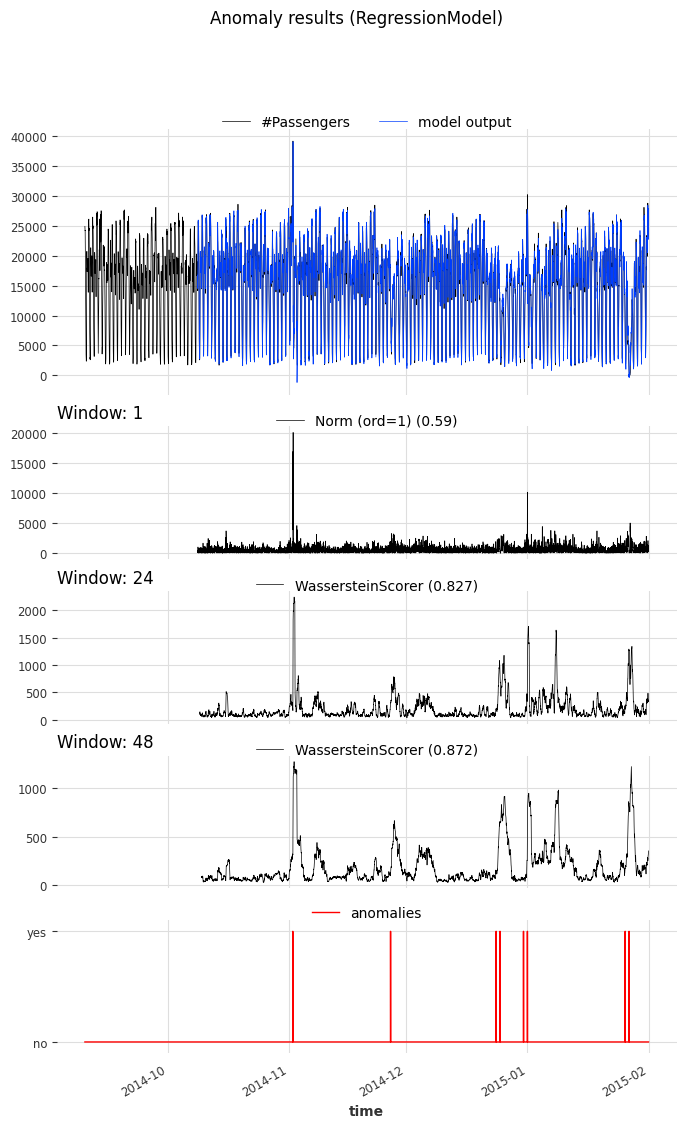

In [84]:
anomaly_model.show_anomalies(
    series=s_taxi_test,
    actual_anomalies=series_taxi_anomalies[3400:],
    start=0.2,
    metric="AUC_ROC",
)
plt.show()

### Using the functions eval_accuracy_from_scores() and show_anomalies_from_scores()

The functions `eval_accuracy()` and `show_anomalies()` call internaly `eval_accuracy_from_scores()` and `show_anomalies_from_scores()`, respectively. Both are located in the `utils.py` file of the anomaly detection module. They can be called directly if we have already computed the scores with the function `score()`. 

The following cells recreate the metric values and the plot seen previously by calling the two functions. 

To compute the accuracy, the `function eval_accuracy_from_scores()` requires the window size value for the scores. It was previously accessed by the function `eval_accuracy()` in the Forecasting anomaly model. Therefore, we must indicate what window was used to compute each score manually. In our case, it is 1, 24, and 48. 

In [85]:
auc_roc_taxi_from_scores = eval_accuracy_from_scores(
    actual_anomalies=series_taxi_anomalies,
    anomaly_score=anomaly_scores,
    window=[1, 24, 48],
    metric="AUC_ROC",
)
auc_pr_taxi_from_scores = eval_accuracy_from_scores(
    actual_anomalies=series_taxi_anomalies,
    anomaly_score=anomaly_scores,
    window=[1, 24, 48],
    metric="AUC_PR",
)

print("AUC ROC:", auc_roc_taxi_from_scores)
print("AUC PR:", auc_pr_taxi_from_scores)

AUC ROC: [0.5899348887683125, 0.8268234059877239, 0.8719903667254211]
AUC PR: [0.04471478801631201, 0.35634779021280705, 0.5680977051640226]


Regarding the function `eval_accuracy_from_scores()`, if we want to compute a metric, we also need to specify the window of each score. Additionally, we can indicate the scorers’ names that generated the scores. 

In [ ]:
show_anomalies_from_scores(
    series=series_taxi,
    actual_anomalies=series_taxi_anomalies,
    anomaly_scores=anomaly_scores,
    window=[1, 24, 48],
    title="Anomaly results using a forecasting method",
    names_of_scorers=["Norm", "WassersteinScorer", "WassersteinScorer"],
    metric="AUC_ROC",
)
plt.show()

<span style="color:red">**COMMENT:** I was expecting to see an example of the detector as well, to display the identified anomalies</span>.

# Simple case: `KMeansScorer`

The following section aims to present the parameter `window` of the scorer `KmeansScorer`. Two examples on toy datasets are used, and the goal is to detect the datasets' anomalies. The first example uses a window of size one on a multivariate time series, and the second uses a window of size two on a univariate time series. 



## Multivariate case with window=1 

### Synthetic data creation

The data is a multivariate series (2 components). The possible values for each timestamp are 0 or 1, and the two components always have opposite values. 
- State 1: component1=0, component2=1
- State 2: component1=1, component2=0

At each timestamp, it has a 50% chance to switch state and a 50% chance to keep the same state. 


#### Train set

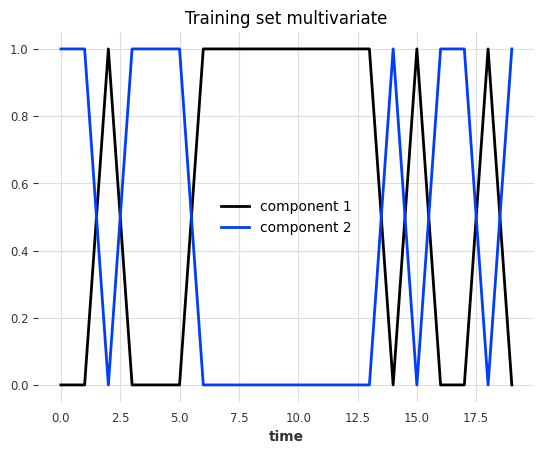

In [86]:
np.random.seed(40)

# create the train set
np_component1 = np.random.choice(a=[0, 1], size=100, p=[0.5, 0.5])
np_component2 = (np_component1 == 0).astype(float)
mts_train = TimeSeries.from_values(
    np.dstack((np_component1, np_component2))[0], columns=["component 1", "component 2"]
)

# visualize the train set
mts_train[:20].plot()
plt.title("Training set multivariate")
plt.show()

#### Test set

We create the test set using the same rules as the train set. Additionally, 6 separate anomalies of 3 different types will be injected in the series (2 anomalies per type). The anomalies can be longer than one timestamp. The types are:
- 1st type: replacing the current values of one width (0 or 1) with 2
- 2nd type: shifting the signal (both widths) by 1 or -1 
- 3rd type: changing the current values of one width (0 or 1) to the other possible value (1 or 0)

In [87]:
# inject anomalies in the test timeseries
np.random.seed(3)
np_component1 = np.random.choice(a=[0, 1], size=100, p=[0.5, 0.5])
np_component2 = (np_component1 == 0).astype(int)

# 2 anomalies per type
# type 1: random values for only one width
np_component1[20:21] = 2
np_component2[30:32] = 2

# type 2: shift both widths values (+/- 1 for both widths)
np_component1[45:47] = np_component1[45:47] + 1
np_component2[45:47] = np_component2[45:47] + 1
np_component1[60:64] = np_component1[65:69] - 1
np_component2[60:64] = np_component2[65:69] - 1

# type 3: switch one state to another for only one width (1 to 0 for one width)
np_component1[75:82] = (np_component1[75:82] != True).astype(int)
np_component2[90:96] = (np_component2[90:96] != True).astype(int)

mts_test = TimeSeries.from_values(
    np.dstack((np_component1, np_component2))[0], columns=["component 1", "component 2"]
)

# create the anomalies binary ground truth series
anomalies_index = [
    20,
    30,
    31,
    45,
    46,
    60,
    61,
    62,
    63,
    75,
    76,
    77,
    78,
    79,
    80,
    81,
    90,
    91,
    92,
    93,
    94,
    95,
]
np_anomalies = np.zeros(len(mts_test))
np_anomalies[anomalies_index] = 1
mts_anomalies = TimeSeries.from_times_and_values(
    mts_test.time_index, np_anomalies, columns=["is_anomaly"]
)

The following plot shows the position of the 6 anomalies. From left to right, the first two anomalies correspond to the 1st type, the third and the fourth correspond to the 2nd type, and the last two to the 3rd type.


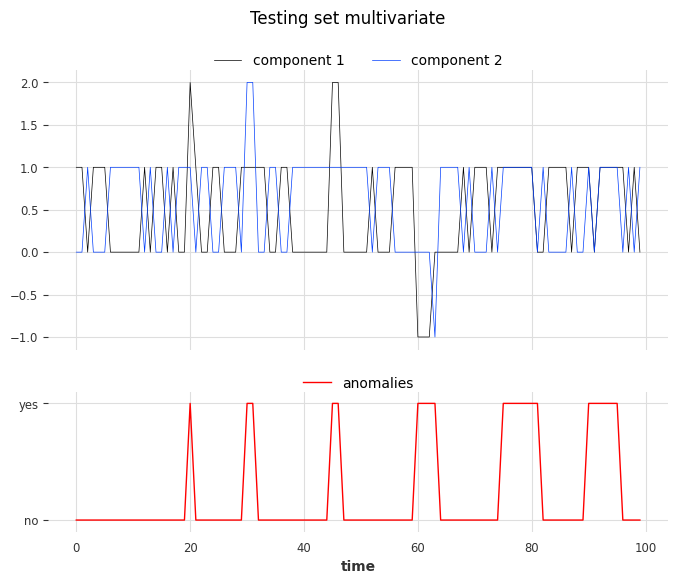

In [88]:
show_anomalies_from_scores(
    series=mts_test, actual_anomalies=mts_anomalies, title="Testing set multivariate"
)
plt.show()

### Use the scorer `KMeansScorer()`

We will use the `KMeansScorer` from the anomaly detection module to locate the anomalies. The scorer has the following parameters:
- `k`=2: The number of centroids to generate by the KMeans model.
- `window`=1 (default): Each timestamp will be considered independently by the KMeans model. It indicates the size of the window used to create the subsequences of the series.
- `component_wise`=False (default): The components will be concatenated in the rolling window. The KMeans model will then capture the relationship between the two components.  

The `KMeansScorer` must be fitted on the training series 'mts_train' with the function `fit()`.

The scorer will return the anomaly score of the series 'mts_test' with the function `score()`.

In [89]:
Kmeans_scorer = KMeansScorer(k=2, window=1, component_wise=False)

# fit the KmeansScorer on the train timeseries 'mts_train'
Kmeans_scorer.fit(mts_train)

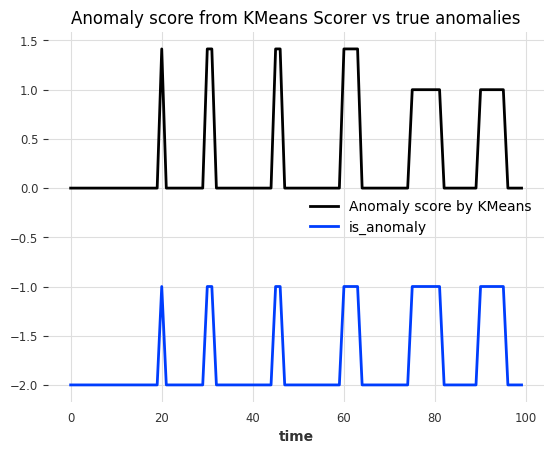

In [90]:
anomaly_score = Kmeans_scorer.score(mts_test)

# visualize the anomaly score compared to the true anomalies
anomaly_score.plot(label="Anomaly score by KMeans")
(mts_anomalies - 2).plot()
plt.title("Anomaly score from KMeans Scorer vs true anomalies")
plt.show()

We can see that the anomaly score accurately indicates the position of the 6 anomalies.

The scorer can evaluate its prediction accuracy thanks to the function `eval_accuracy()`. It takes as input the true anomalies, the series, and the name of the agnostic threshold metric (AUC-ROC or AUC-PR). It will return the accuracy of the indicated metric (value between 0 and 1). 

In [40]:
metric_auc_roc = Kmeans_scorer.eval_accuracy(mts_anomalies, mts_test, metric="AUC_ROC")
metric_auc_pr = Kmeans_scorer.eval_accuracy(mts_anomalies, mts_test, metric="AUC_PR")

print("AUC ROC: {}/1, AUC PR: {}/1".format(metric_auc_roc, metric_auc_pr))

AUC ROC: 1.0/1, AUC PR: 1.0/1


To visualize the results correctly, the scorer has a function, `show_anomalies()`, that returns a plot with all the information. 

It will show the following:
- the series 
- the anomaly score of the series 
- the accuracy of the indicated metric (default AUC_ROC)
- the actual anomalies (on a different plot)

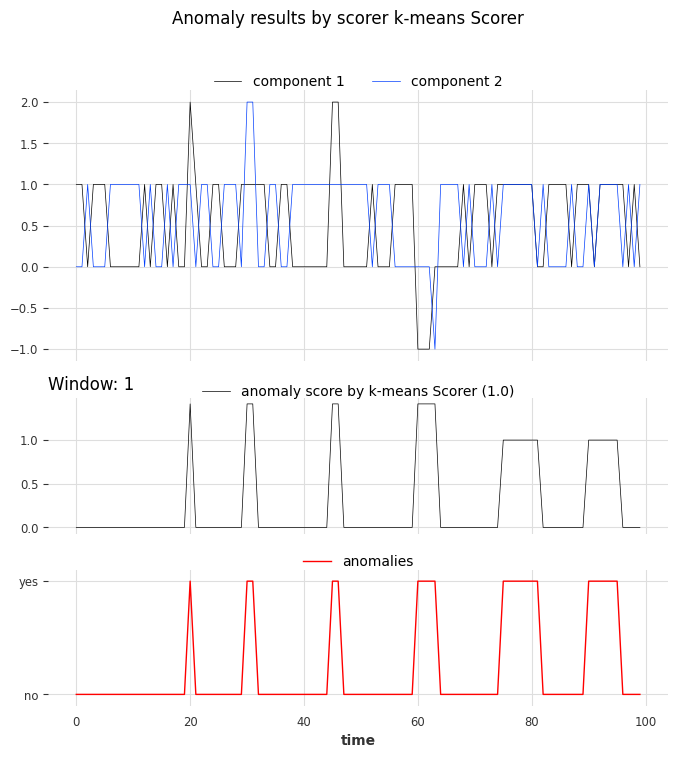

In [41]:
Kmeans_scorer.show_anomalies(
    series=mts_test, actual_anomalies=mts_anomalies, metric="AUC_ROC"
)
plt.show()

## Univariate case with window>1 

In the previous example, the parameter `window` was set to 1, sufficient to identify the anomalies. The following example will show the utility of using a higher value for the parameter when the anomalies are sequences with values that are not necessarily anomalous. 


### Synthetic data creation

#### Train set

The considered series is univariate (one component) and can take 4 possible values for each timestamp (0, 1, 2, and 3).
At each timestamp, the series has a 50 % chance to increase state (+1) or 50% to decrease state (-1). If the current value is 3 (is 0), and the next state is supposed to be +1 (-1), the next value will be set to 3 (to 0). The series is upper bounded/lower bounded by 3/0. 

As a result, a sequence will be considered anomalous if it contains a jump higher than two or if more than one consecutive timestamp is at state 1 or state 2. 


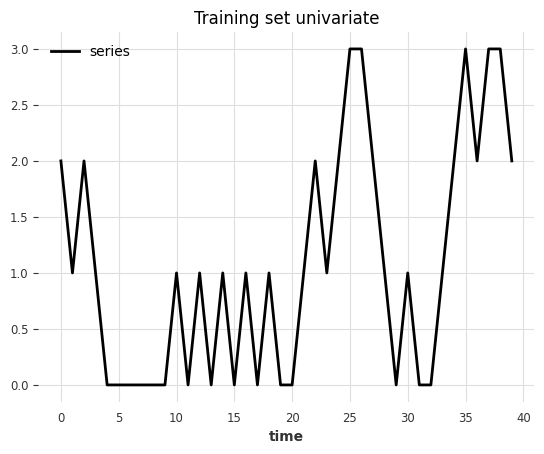

In [94]:
np.random.seed(1)

# create the train set
np_series = np.zeros(100)
np_series[0] = 2

for i in range(1, len(np_series)):
    np_series[i] = np_series[i - 1] + np.random.choice(a=[-1, 1], p=[0.5, 0.5])
    if np_series[i] > 3:
        np_series[i] = 3
    if np_series[i] < 0:
        np_series[i] = 0

ts_train = TimeSeries.from_values(np_series, columns=["series"])

# visualize the train set
ts_train[:40].plot()
plt.title("Training set univariate")
plt.show()

#### Test set

We create the test set using the same rules as the train set. Additionally, 6 separate anomalies of 2 different types will be injected in the series (3 anomalies per type). The anomalies can be longer than one timestamp. The types are:
- 1st type: sudden shift between states that are more than 1 step apart (ex: state 0 to state 2, or state 1 to state 3)  
- 2nd type: more than one consecutive timestamp that are at state 1 or state 2. 


In [95]:
np.random.seed(3)

# create the test set
np_series = np.zeros(100)

np_series[0] = 1

for i in range(1, len(np_series)):
    np_series[i] = np_series[i - 1] + np.random.choice(a=[-1, 1], p=[0.5, 0.5])
    if np_series[i] > 3:
        np_series[i] = 3
    if np_series[i] < 0:
        np_series[i] = 0


# 3 anomalies per type
# type 1: sudden shift between state 0 to state 2 without passing by state 1
np_series[23] = 3
np_series[44] = 3
np_series[91] = 0

# type 2: having consecutive timestamps at state 1 or 2
np_series[3:5] = 2
np_series[17:19] = 1
np_series[62:65] = 2

ts_test = TimeSeries.from_values(np_series, columns=["series"])

# create the anomalies binary ground truth series
anomalies_index = [4, 23, 18, 44, 63, 64, 91]
np_anomalies = np.zeros(100)
np_anomalies[anomalies_index] = 1
ts_anomalies = TimeSeries.from_times_and_values(
    ts_test.time_index, np_anomalies, columns=["is_anomaly"]
)

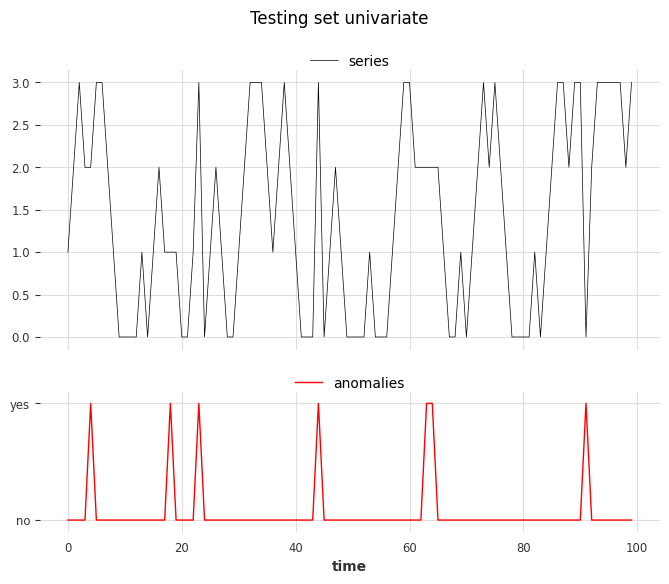

In [96]:
show_anomalies_from_scores(
    series=ts_test, actual_anomalies=ts_anomalies, title="Testing set univariate"
)
plt.show()

From left to right, anomalies at positions 1, 3, and 4 are of type 1, and anomalies at positions 2, 5, and 6 are of type 2. 

### Use the scorer `KMeansScorer()`

We fit two `KMeansScorer` with different values for the `window` parameter (1 and 2).

In [97]:
Kmeans_scorer_w1 = KMeansScorer(k=4, window=1)
Kmeans_scorer_w1.fit(ts_train)
score_w1 = Kmeans_scorer_w1.score(ts_test)

In [98]:
Kmeans_scorer_w2 = KMeansScorer(k=8, window=2)
Kmeans_scorer_w2.fit(ts_train)
score_w2 = Kmeans_scorer_w2.score(ts_test)

In [99]:
auc_roc_w1 = Kmeans_scorer_w1.eval_accuracy(ts_anomalies, ts_test, metric="AUC_ROC")
auc_pr_w1 = Kmeans_scorer_w1.eval_accuracy(ts_anomalies, ts_test, metric="AUC_PR")

auc_roc_w2 = Kmeans_scorer_w2.eval_accuracy(ts_anomalies, ts_test, metric="AUC_ROC")
auc_roc_w2 = Kmeans_scorer_w2.eval_accuracy(ts_anomalies, ts_test, metric="AUC_PR")

print(
    "For window 1: AUC ROC={}/1 and AUC PR={}/1".format(
        round(auc_roc_w1, 2), round(auc_pr_w1, 2)
    )
)
print(
    "For window 2: AUC ROC={}/1 and AUC PR={}/1".format(
        round(auc_roc_w2, 2), round(auc_roc_w2, 2)
    )
)

For window 1: AUC ROC=0.42/1 and AUC PR=0.06/1
For window 2: AUC ROC=0.89/1 and AUC PR=0.89/1


The metric indicates that the scorer with the parameter window set to 1 cannot locate the anomalies. On the other hand, the scorer with the parameter set to 2 locates the anomalies with great precision.  


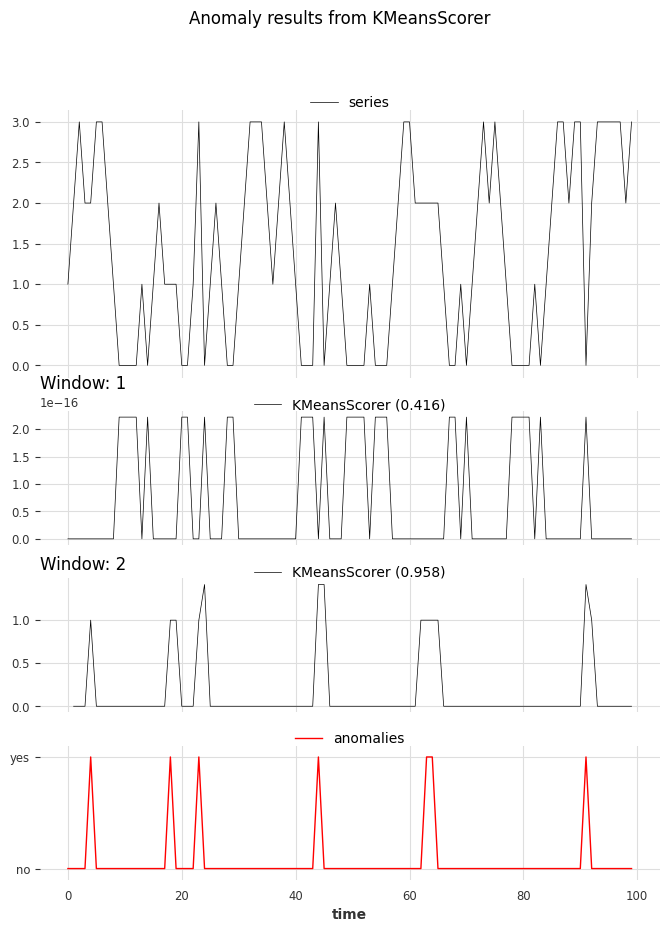

In [48]:
show_anomalies_from_scores(
    series=ts_test,
    actual_anomalies=ts_anomalies,
    anomaly_scores=[score_w1, score_w2],
    names_of_scorers=["KMeansScorer", "KMeansScorer"],
    window=[1, 2],
    metric="AUC_ROC",
    title="Anomaly results from KMeansScorer",
)
plt.show()

We can see the accurate prediction of the scorer with a window of 2 compared to that of the scorer with a window of 1. 